In [18]:
import os
import time
import copy
import urllib.request
import zipfile

# PyTorch
import torch
from torch import nn
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Avalanche
from avalanche.benchmarks import dataset_benchmark
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import LwF

# Matplotlib
import matplotlib.pyplot as plt

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [19]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 30             # Number of training epochs
num_experiences = 50        # Number of experiences
train_mb_size=32            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss
start_time = time.time()    # Start of the computation timer

In [20]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [21]:
# 1. Download Tiny ImageNet dataset and extract it
def download_tiny_imagenet(data_dir):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_file = os.path.join(data_dir, "tiny-imagenet-200.zip")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if not os.path.exists(zip_file):
        print("Downloading Tiny ImageNet dataset...")
        urllib.request.urlretrieve(url, zip_file)

    extracted_dir = os.path.join(data_dir, "tiny-imagenet-200")
    if not os.path.exists(extracted_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

    return extracted_dir

data_dir = "./data"
tiny_imagenet_dir = './data/tiny-imagenet-200'

# Organize validation set (if needed, we will move the images based on their annotations)
val_dir = os.path.join(tiny_imagenet_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Create class subdirectories in the validation folder
def organize_val_images(val_dir, val_images_dir, val_annotations_file):
    if not os.path.exists(val_images_dir):
        return  # Already organized

    print("Organizing validation images into class folders...")
    with open(val_annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_file, class_id = parts[0], parts[1]
            class_dir = os.path.join(val_dir, class_id)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            
            # Move images into corresponding class folder
            img_src_path = os.path.join(val_images_dir, img_file)
            img_dst_path = os.path.join(class_dir, img_file)
            if os.path.exists(img_src_path):
                os.rename(img_src_path, img_dst_path)

    # Remove the original images folder
    if os.path.exists(val_images_dir):
        os.rmdir(val_images_dir)

organize_val_images(val_dir, val_images_dir, val_annotations_file)

In [22]:
# 2. Define transformations and load Tiny ImageNet data using ImageFolder
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train and validation datasets
train_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'train'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'val'), transform=transform)

In [23]:
# 3. 将 train_dataset 分为 50 个 experience
dataset_len = len(train_dataset)
subset_size = dataset_len // num_experiences

# random_split 用于将 train_dataset 划分为 num_experiences 个子集
train_subsets = random_split(train_dataset, [subset_size] * (num_experiences - 1) + [dataset_len - subset_size * (num_experiences - 1)])

# 使用 dataset_benchmark 创建 50 个 experience 的基准
benchmark = dataset_benchmark(
    train_datasets=train_subsets,  # 切分后的 50 个子集
    test_datasets=[val_dataset] * num_experiences  # 每个 experience 使用相同的验证集
)

In [24]:
# labels = [label for _, label in train_dataset]
# print(f"Min label: {min(labels)}, Max label: {max(labels)}")


In [25]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

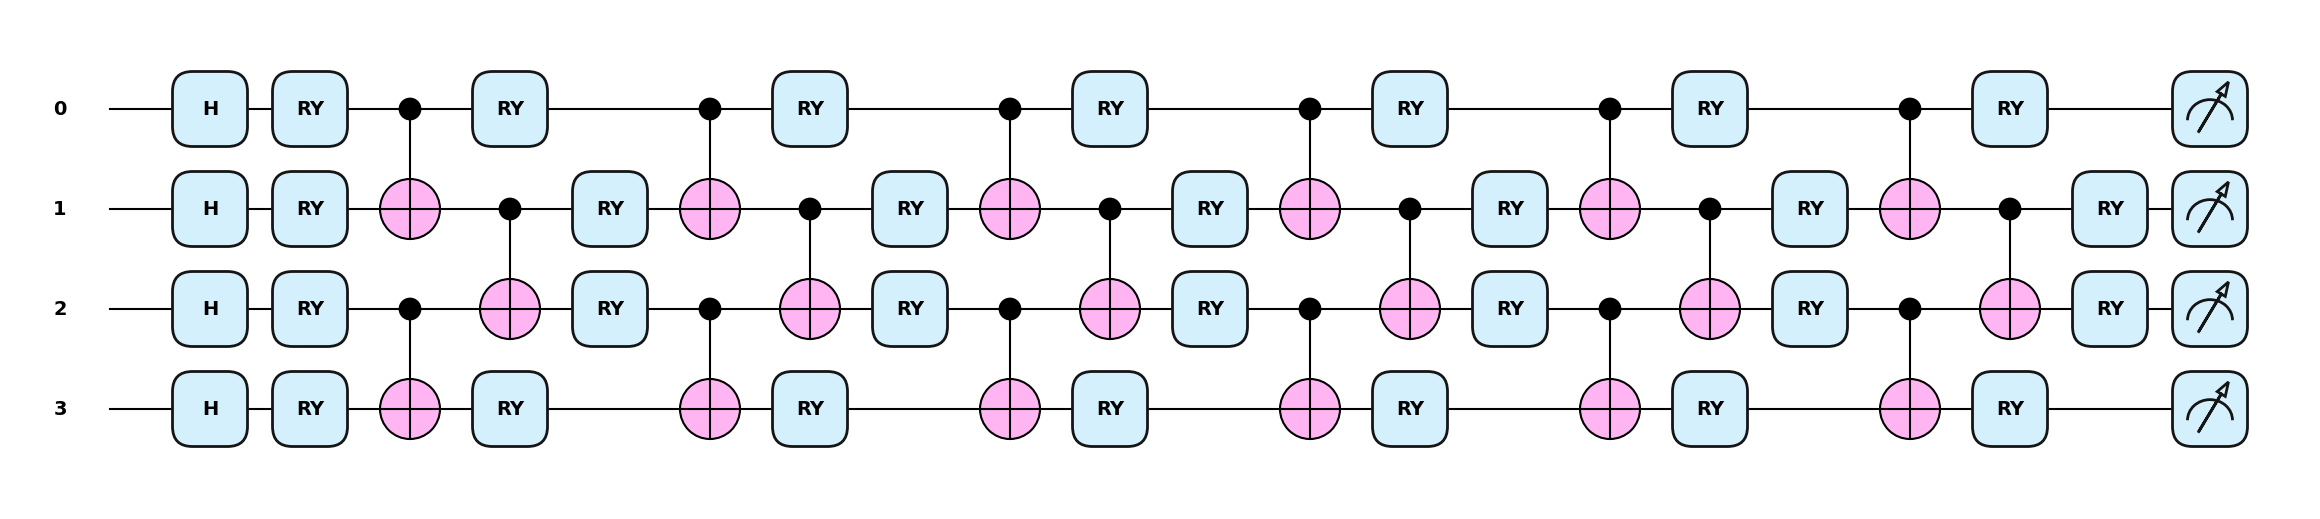

In [26]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [27]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 200)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features.to(device))
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem.to(device)))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [28]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()
# model_hybrid.fc = nn.Linear(512, 200)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [29]:
from torch.utils.data import DataLoader
# 为数据创建 DataLoader
train_loader = DataLoader(train_subsets[0], batch_size=32, shuffle=True)

# 获取一个 batch 的数据
inputs, labels = next(iter(train_loader))

# 确保输入数据的形状是 [batch_size, channels, height, width]
print(f"Input shape: {inputs.shape}")  # 应该是 [batch_size, 3, 64, 64]

# 将输入传递给模型
outputs = model_hybrid(inputs.to(device))
print(f"Model output shape: {outputs.shape}")  # 应该是 [batch_size, 200]

Input shape: torch.Size([32, 3, 64, 64])
Model output shape: torch.Size([32, 200])


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
# exp_lr_scheduler = lr_scheduler.StepLR(
#     optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
# )

In [32]:
# 7. Define evaluation plugin for logging metrics
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True),
    timing_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

In [33]:
strategy = LwF(
    model=model_hybrid,
    optimizer=optimizer_hybrid,
    criterion=criterion,
    alpha=alpha,  # 平衡新任务和旧任务损失的权重
    temperature=temperature,  # 蒸馏温度，越高的值越软化
    train_mb_size=train_mb_size,
    train_epochs=num_epochs,
    eval_mb_size=eval_mb_size,
    evaluator=eval_plugin,
    device=device
)

In [34]:
# Save training accuracy and loss history for plotting
accuracy_history = []
loss_history = []

# 9. Training and evaluation loop
# Use experiences from Avalanche's benchmark, such as from benchmark.train_stream
for epoch in range(num_epochs):  # 训练 4 个 epoch
    print(f"Training epoch {epoch}")
    
    # Iterate over experiences from the benchmark's training stream
    for experience in benchmark.train_stream:
        # Train on the current experience
        strategy.train(experience)
    
    # 在每个 epoch 后进行评估
    results = strategy.eval(benchmark.test_stream)
    # print('*************',results.keys())
    
    # Save accuracy and loss
    for key in results.keys():
        if 'Top1_Acc_Exp' in key:  # 寻找包含 Top1_Acc_Exp 的键
            accuracy_history.append(results[key])
            print(f"Added accuracy for {key}: {results[key]}")
        if 'Loss_Exp' in key:  # 寻找包含 Loss_Exp 的键
            loss_history.append(results[key])
            print(f"Added loss for {key}: {results[key]}")

Training epoch 0
-- >> Start of training phase << --


100%|██████████| 63/63 [02:06<00:00,  2.00s/it]
Epoch 0 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.2117
100%|██████████| 63/63 [02:04<00:00,  1.98s/it]
Epoch 1 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.2077
100%|██████████| 63/63 [02:06<00:00,  2.00s/it]
Epoch 2 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.3519
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 63/63 [03:04<00:00,  2.93s/it]
Epoch 0 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.1925
100%|██████████| 63/63 [03:04<00:00,  2.94s/it]
Epoch 1 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.4491
100%|██████████| 63/63 [03:02<00:00,  2.89s/it]
Epoch 2 ended.
	Loss_MB/train_phase/train_stream/Task000 = 5.5233
-- >> End of training phase << --
-- >> Start of training phase << --
 70%|██████▉   | 44/63 [02:07<00:55,  2.90s/it]

KeyboardInterrupt: 

In [ ]:
# 10. Plot accuracy and loss over epochs
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.tight_layout()
plt.savefig('lwf_tiny_imagenet_quantum.png')
plt.show()